In [102]:

import torch 
import trimesh 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sea

plt.style.use('ggplot')
colormap1 = plt.get_cmap('Reds')
colormap2 = plt.get_cmap('Blues')

gripper = trimesh.load('../gripper.obj')

### Load all the output files

In [103]:
TEMP_DIR = '../temp/'

output = trimesh.load(f'{TEMP_DIR}/only_output_mesh.obj') # the object mesh used during inference
pred_grasps = torch.load(f'{TEMP_DIR}/ouput_dual_grasps.pt').detach().cpu().numpy() # predicted grasps
energy = torch.load(f'{TEMP_DIR}/output_energy.pt').detach().cpu().numpy() # predicted grasp energies
traj = torch.load(f'{TEMP_DIR}/grasps_traj.pt') # the denoising trajectory
fc_scores = torch.load(f'{TEMP_DIR}/grasp_scores.pt').reshape(-1) # predicted force-closure scores
collision_scores = torch.load(f'{TEMP_DIR}/collision_scores.pt').reshape(-1, 2) # predicted collision scores
P = torch.load(f'{TEMP_DIR}/point_cloud.pt').reshape(-1, 3)
rot = torch.load(f'{TEMP_DIR}/rotation.pt') # random rotation applied during inference

pcd = trimesh.PointCloud(P @ rot)
pcd.colors = [255, 0, 0]

T = np.eye(4)
T[:3, :3] = rot.T

pred_grasps = T[None, None, ...] @ pred_grasps
traj = T[None, None, ...] @ traj
output.apply_transform(T)

<trimesh.Trimesh(vertices.shape=(1248, 3), faces.shape=(2492, 3))>

### Preprocess the files

- Here, we sort all the generated grasp pairs by the energy value.

- Lower energy corresponds to grasps physically grounded on the object surface while higher energy means the grasp pairs are still floating in the free space.

- Some grasps will have lower `Force-Closure Score`, which can be removed by thresholding


<Axes: title={'center': 'Force-Closure Score'}, ylabel='Count'>

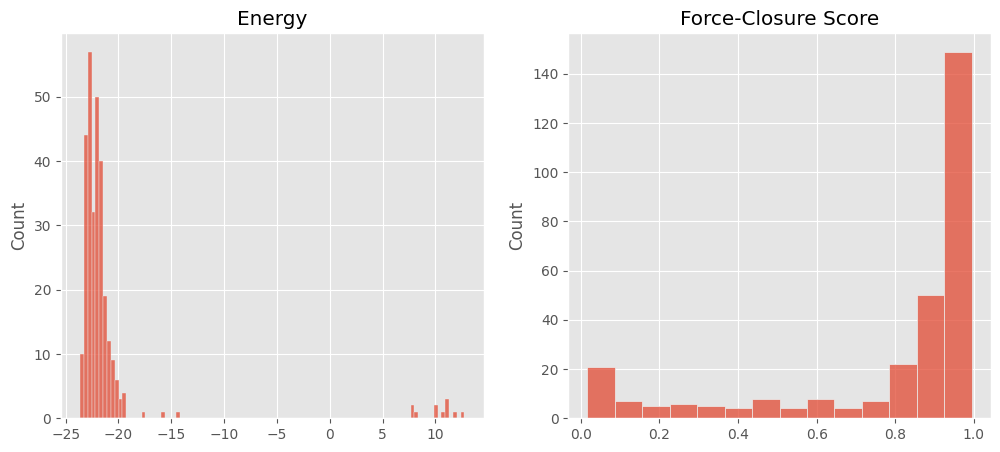

In [161]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Energy')
sea.histplot(energy)

plt.subplot(1, 2, 2)
plt.title('Force-Closure Score')
sea.histplot(fc_scores)


In [176]:
# idx = np.argsort(energy)[200]
idx = 252

gripper_left = gripper.copy()
gripper_right = gripper.copy()

gripper_left.apply_transform(pred_grasps[idx, 0])
gripper_left.visual.face_colors = [0, 255, 0]
gripper_right.apply_transform(pred_grasps[idx, 1])


print(f"Energy: {energy[idx].item()}")
print(f'Force-Closure Score: {fc_scores[idx].item()}')
print(f'Collision Score: {collision_scores[idx]}')


Energy: -22.641246795654297
Force-Closure Score: 0.9844402074813843
Collision Score: [0.67724067 0.6687529 ]


### Visualize the predicted dual-arm grasps

- Change the above `idx` to view different grasps

In [177]:
grippers_left, grippers_right = [], []
spheres_left, spheres_right = [], []
lines = []


colors_left = colormap1(np.linspace(0, 1, len(traj)))
colors_right = colormap2(np.linspace(0, 1, len(traj)))

traj_now = []

for i in range(0, len(traj)):
    gripper_left_temp = gripper.copy()
    gripper_left_temp.visual.face_colors = colors_left[i]
    gripper_left_temp.apply_transform(traj[i, 2*idx, ...])
    sphere = trimesh.creation.icosphere(radius=0.005)
    sphere.apply_translation(traj[i, 2*idx, :3, 3])
    sphere.visual.face_colors = [255, 0, 0]
    spheres_left.append(sphere) 
    grippers_left.append(gripper_left_temp)
    
 
    gripper_right_temp = gripper.copy()
    gripper_right_temp.visual.face_colors = colors_right[i]
    gripper_right_temp.apply_transform(traj[i, 2*idx + 1, ...])
    grippers_right.append(gripper_right_temp)
    sphere = trimesh.creation.icosphere(radius=0.005)
    sphere.apply_translation(traj[i, 2*idx + 1, :3, 3])
    sphere.visual.face_colors = [0, 0, 255]
    spheres_right.append(sphere)
    
    traj_now.append(np.asarray([traj[i, 2*idx, ...], traj[i, 2*idx + 1, ...]]))

traj_now = np.asarray(traj_now)

coordinate_frame = trimesh.creation.axis(origin_size=1e-2) 

scene = trimesh.Scene([output, pcd, gripper_left, gripper_right, coordinate_frame])

scene.show()


### Visualize the denoising trajectory

In [178]:
skip_steps = 10
lines = []
show_lines = False

if show_lines:
    for i in range(0, len(spheres_left)-skip_steps, skip_steps):
        line = trimesh.creation.cylinder(radius=0.00025, 
                                        segment=[spheres_left[i].centroid, spheres_left[i+skip_steps].centroid])
        lines.append(line)
        
        line = trimesh.creation.cylinder(radius=0.00025,
                                        segment=[spheres_right[i].centroid, spheres_right[i+skip_steps].centroid])
        lines.append(line)

scene = trimesh.Scene([output, pcd, grippers_left[::skip_steps], grippers_right[::skip_steps], 
                       coordinate_frame, spheres_left[::skip_steps], spheres_right[::skip_steps],    
                       lines if show_lines else None])
scene.show()